<a href="https://colab.research.google.com/github/pushkershukla/adv_fairness/blob/main/Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled 

In [2]:
# all imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import PIL.Image as Image

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models
import torch.utils.data as data
import zipfile
import pandas as pd
import torchvision
import time
from torch.utils.data import Dataset
from tqdm import tqdm
# reproducibility
seed = 42
# SYSTEM
np.random.seed(seed)
#CUDA
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)
# CUDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# version
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 2.0.1+cu118
GPU-enabled installation? True


In [3]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset_dir='/content/gdrive/MyDrive/downloads/celeba/celeba.zip'

with zipfile.ZipFile(dataset_dir,"r") as zip_ref:
  zip_ref.extractall("faces/")

with zipfile.ZipFile("faces/celeba/img_align_celeba.zip","r") as zip_ref:
  zip_ref.extractall("faces/celeba")

In [5]:
image_path="faces"
data_root='faces/celeba'
dataset_folder = f'{data_root}/img_align_celeba'
print(dataset_folder)

faces/celeba/img_align_celeba


## Data Loading
Code for loading the dataset

In [6]:
'''
Hyper parameters for dataloaders
'''
batch_size = 128
smile_attr_idx=31
gender_attr_idx=20
GRAYSCALE = False
num_classes=2
num_epochs=15

noise_setting_1={#'0':{'eps':0},
                '0.00001':{'eps':0.00001},
                '0.0001':{'eps':0.0001},
                '0.0005':{'eps':0.0005},
                #'0.0007':{'eps':0.0007},
                '0.001':{'eps':0.001},
                '0.003':{'eps':0.003},
                '0.005':{'eps':0.05},
                '0.01':{'eps':0.05},
                '0.25':{'eps':0.25}
                }

In [7]:
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
     transforms.RandomCrop([178, 178]),
     transforms.RandomHorizontalFlip(),
     transforms.Resize([128, 128]),
     transforms.ToTensor(),
 ])
transform = transforms.Compose([
     transforms.CenterCrop([178, 178]),
     transforms.Resize([128, 128]),
     transforms.ToTensor(),
 ])

celeba_train_dataset = torchvision.datasets.CelebA(
     image_path, split='train',
     target_type='attr', download=False,
     transform=transform_train
 )


celeba_valid_dataset = torchvision.datasets.CelebA(
     image_path, split='valid',
     target_type='attr', download=False,
     transform=transform
 )
celeba_test_dataset = torchvision.datasets.CelebA(
     image_path, split='test',
     target_type='attr', download=False,
     transform=transform
 )
train_dl = DataLoader(celeba_train_dataset,
                       batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,
                       batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset,
                     batch_size, shuffle=False)
print('Train set:', len(celeba_train_dataset))

print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_valid_dataset))

Train set: 162770
Validation set: 19867
Test set: 19867


## Setting up the Resent 18 model

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #print("Shape of input",x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probas = F.softmax(logits, dim=0)

        return  probas




def resnet18(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck,
                   layers=[2,2,2,2],
                   #layers=[3, 4, 23, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

def load_model(model,model_name,model_path,device):
  final_path=os.path.join(model_path,model_name)

  model = model.to(device)
  model_weights = torch.load(final_path,map_location=device)
  model.load_state_dict(model_weights)
  #model.eval()
  return model

def comp_model(model1,model2):
  for p1, p2 in zip(model1.parameters(), model2.parameters()):
      if p1.data.ne(p2.data).sum() > 0:
          return False
  return True

def get_pred(local_model, images, device,logits='False'):
    logits = local_model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres,logits



def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()
class single_output_network(nn.Module):
    def __init__(self,input_network):
      super(single_output_network, self).__init__()
      self.input_network=input_network
    def forward(self,x):
      probas= self.input_network(x)
      #print(len (probas))
      return probas[1]



### Loading the already trained smile and gender models.

In [10]:
#smile_model_name="smile_model_new__single_out_resnet50.pt"
#smile_save_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"
smile_model_name="smile_model_new_resnet50.pt"
smile_save_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"
model_smile = resnet18(num_classes, GRAYSCALE)
model_smile= load_model(model_smile,smile_model_name,smile_save_path,device)
#model_smile=single_output_network(model_smile)
model_smile=model_smile.to(device)

In [11]:
#gender_model_name="gernder_model_new__single_out_resnet50.pt"
#gender_save_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"
gender_model_name="gender_model2_new_resnet50.pt"
gender_save_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"
model_gender=resnet18(num_classes, GRAYSCALE)
model_gender=load_model(model_gender,gender_model_name,gender_save_path,device)
#model_gender=single_output_network(model_smile)
model_gender=model_gender.to(device)


## Adversarial Analysis section

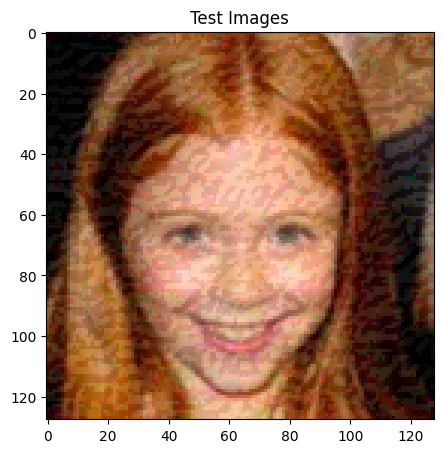

In [12]:
import torchattacks

class Adverserial_Analysis:
    def __init__(self,atk_name,classifier,concept_model,
                 classifier_pred,concept_pred,
                 classifier_pred_kwargs,concept_pred_kwargs,
                 atk_kwargs):

      '''
      Variables :-
      atk_name :- Name of the attack
      classifier :- the oroginal classifier model (Eg:- Smile detector model or Melanoma Classifier)
      concept_model:- The concept_detection model (Eg:- Skin detector or gender classifier)
      classifier_pred :- The function returning the output of the classifier. The output
                          should be a tuple containing the class index and output probabilities of the classifier
      concept_pred :- The function returning the output of the concept. The output
                          should be a tuple containing the class index and output probabilities of the classifier

      classifier_pred_kwargs :- Dictionary containting the parameters associated with the classifier function
      concept_pred_kwargs:-  Dictionary containting the parameters associated with the concept
      atk_kwargs :- Dictionary containing the parameters associated with the adverserial attack
      '''
      self.atk_name=atk_name
      self.classifier=classifier
      self.concept_model=concept_model
      self.classifier_pred=classifier_pred
      self.concept_pred=concept_pred
      self.classifier_pred_kwargs=classifier_pred_kwargs
      self.concept_pred_kwargs=concept_pred_kwargs
      self.atk_kwargs=atk_kwargs
      self.atk=None


    def generate_adverserial_attack(self,atk_name,kwargs=None):
      '''
      Function that returns the adequate adveserial attack
      Input :-
      atk_name - Name of the attack
      kwargs:- Paramaeters associated with the attack
      Output :- the attack initialized
      '''
      #print("Attack _name",atk_name)
      #print("Kwargs",kwargs)
      atk=None
      if kwargs is None:
        kwargs=self.atk_kwargs
      if atk_name is None:
        atk_name = self.atk_name
      if (atk_name=='Square'):
        atk= torchattacks.Square(self.concept_model,**kwargs)
      if (atk_name=='FGSM'):
        atk= torchattacks.FGSM(self.concept_model,**kwargs)
      if (atk_name=='BIM'):
        pass
      if (atk_name=='PGD'):
        pass
      if (atk_name=="OnePixel"):
        pass
      if (atk_name=="random") :
        print("there")
        atk= torchattacks.attacks.gn.GN(self.concept_model,**kwargs)
      #print( "Torch attack USed",atk)
      return atk
    def generate_adverserial_images(self,imgs,classifier_fn=None,
                                    pred_fn=None,pred_kwargs=None,
                                    atk_name=None,atk_kwargs=None,labels=None):
        '''
        Generates Adverserial Images for a given attack
        Input:-
        imgs:- A single image or a bunch of images
        classifier_fn:- The classifier that is to be fooled (Deafult :- Concept Classifier , Eg:- Gender for a smile classifier)
        pred_fn:- The associated prediction function with the classifier_fn (Default:- Concept pred_fn)
        pred_kwargs:- kwargs of the prediction function , Input Type :- Dictionary
        atk_name:- Name of the attack
        atk_kwargs:- Parameters associated with the attack type , Input Type:- Dictionary
        Output:-
        Returns an image or a set of imgaes that have been corrupted by the respective adverserial attack
        '''
        #print(atk_name)
        if (imgs.dim()==3):
            imgs=imgs.unsqueeze(dim=0)
        if classifier_fn is None:
          classifier_fn=self.concept_model
        if atk_name is None:
          atk_name =self.atk_name
        if atk_kwargs is None:
          atk_kwargs=self.atk_kwargs
        if pred_fn is None:
          pred_fn=self.concept_pred
        if pred_kwargs is None:
          pred_kwargs=self.concept_pred_kwargs

        atk=self.generate_adverserial_attack(atk_name,atk_kwargs)
        preds,_=pred_fn(classifier_fn,imgs,**pred_kwargs)
        preds=preds.type(torch.LongTensor)

        #print(preds.dtype,imgs.dtype)

        if labels is None :
          return  atk(imgs,preds), preds
        else :
          labels=labels.type(torch.LongTensor)
          return atk (imgs,labels), labels

    def get_classifier_values(self,imgs):
      '''
      Funtion to generate outputs (logits and classes) from the classifier and the concept model
      Input :-
      imgs:- Image or a set of images
      Output:-
      The output is a tuple containing (clssifier_pred,classifier_logits, concept_pred,concept_logits)
      where
      classifier_pred is the output class returned by the classifier
      classifier_logits are the output logits returned by the classifier
      concept_pred is the output class returned by the concept model
      concept_logits are the output logits returned by the concept model


      '''

      ## Note define a seperate class for the the hyperparameters of the class function.

      if (imgs.dim()==3):
        imgs=imgs.unsqueeze(dim=0)
      adv_clssifier_pred,adv_classifier_logits=self.classifier_pred(self.classifier,imgs,**self.classifier_pred_kwargs)
      adv_concept_pred,adv_concept_logits=self.concept_pred(self.concept_model,imgs,**self.concept_pred_kwargs)
      return (adv_clssifier_pred,adv_classifier_logits.detach(),adv_concept_pred,adv_concept_logits.detach())
    def loop_over_noise(self,imgs,noise_settings,
                        pred_fn=None,pred_kwargs=None,
                        classifier_fn=None,atk_name=None,
                        atk_kwargs=None,labels=None):
      '''
      Given different noise magnitudes, the funnction returns a dictionary of predictions over different noise magnitudes

      '''

      adv_imgs=[]
      final_labels=[]
      class_preds={}
      if pred_fn is None:
        pred_fn=self.concept_pred
      for noise_magnitude,atk_kwargs in noise_settings.items():

        adverserial_imgs,pred_labels=self.generate_adverserial_images(imgs,classifier_fn,
                                    pred_fn,pred_kwargs,
                                    atk_name,atk_kwargs,labels)

        preds=self.get_classifier_values(adverserial_imgs)
        class_preds.update({str(noise_magnitude):preds})
        adv_imgs.extend(adverserial_imgs)
        final_labels.extend(pred_labels)
        #print(adv_images[0].shape,adv_images[1].shape)


      return adv_imgs, class_preds,pred_labels
    def generate_random_noise(self,method):
      pass
    def show_image_plots():
      pass


'''
Test Cases
'''
it=iter(test_dl)
images,labels=next(it)
gender_labels=labels[:,gender_attr_idx]
smile_labels=labels[:,smile_attr_idx]
images=images.to(device)
#print ("Image Shape",images.shape)
#output=model_smile(images)

#print(get_pred(model_gender,images,device))
#_, pres = output.max(dim=1)
#print(pres.shape)

adv_analyzer=Adverserial_Analysis("FGSM",model_smile,model_gender,
                                  get_pred,get_pred,
                                  {'device':device,'logits':False},{'device':device,'logits':False},
                                  {'eps':0.05})
#print(images.shape)
adv_images,adv_labels=adv_analyzer.generate_adverserial_images(images,classifier_fn=None,
                                    pred_fn=None,pred_kwargs=None,
                                    atk_name=None,atk_kwargs=None,labels=gender_labels)

#print(adv_images.shape )


adv_imgs, class_preds,label_set = adv_analyzer.loop_over_noise(images,noise_setting_1,
                        pred_fn=None,pred_kwargs=None,
                        classifier_fn=None,atk_name=None,
                        atk_kwargs=None,labels=gender_labels)
#print(adv_images.shape)
imshow(adv_images[2],"Test Images")


In [13]:
print()
#print (get_pred(model_smile,images,device))
#print (get_pred(model_gender,adv_images,device))

# Metrics

In [14]:
def evaluate(model,dataloader,protected_attr_idx,labels_idx):
    '''
    Calls a data loader, predicts the outputs and returns the outputs and the original data in pandas dataframe
    '''
    protected_attrs=[]
    true_labels=[]
    predictions=[]
    for i , (inputs,labels) in enumerate(dataloader):
        inputs=inputs.to(device)
        labels=labels.to(device)
        model=model.to(device)

        outputs,_=model(inputs)
        #print(outputs)


        _,preds = torch.max(outputs, 1)
        #print(preds)
        predictions.extend(preds.tolist())
        protected_attr=labels[:,protected_attr_idx]
        true_label=labels[:,labels_idx]
        protected_attrs.extend(protected_attr.tolist())
        true_labels.extend(true_label.tolist())
    print("True label",true_labels)
    print ("Protected Attribute",protected_attrs)
    print("Predicted Value", predictions)
    df=pd.DataFrame(columns=["True Labels", "Protected Atrributes", "Predicted Value"])
    df["True Labels"]=true_labels
    df["Protected Atrributes"]=protected_attrs
    df["Predicted Value"]=predictions
    return df
from sklearn.metrics import accuracy_score
def calc_accuracy_df (df):
    '''
    Calculates the accuracy
    '''
    true_labels = df["True Labels"]
    predicted_values = df["Predicted Value"]

    accuracy = accuracy_score(true_labels, predicted_values)
    return accuracy
def group_wise_accuracy (df):
    '''
    Returns the group wise accuracy of the model
    '''
    accuracy_results = {}
    groups = df["Protected Atrributes"].unique()
    classes = df["True Labels"].unique()

    for group in groups:
      for class_label in classes:
        subset_df = df[(df["Protected Atrributes"] == group) & (df["True Labels"] == class_label)]
        true_labels = subset_df["True Labels"]
        predicted_values = subset_df["Predicted Value"]
        accuracy = accuracy_score(true_labels, predicted_values)
        accuracy_results[(group, class_label)] = accuracy

    print(accuracy_results)

def fairness_metrics ():
  '''
  Returns the fair metrics of the model
  '''
def compute_accuracy(y_hat, all_y_true, label_names, acc_matrix, target_attribute):
    label_order = {label_names[i] : i for i in range(len(label_names))}
    y_true = all_y_true[:, label_order[target_attribute]].unsqueeze(dim=1)

    correct = y_hat.eq(y_true.view_as(y_hat)).sum()
    acc_value = (correct.float() / y_true.shape[0]).detach().item()

    # Update the accuracy matrix
    for i in range(y_hat.shape[0]):
        pred = y_hat[i]
        sample = all_y_true[i]
        is_male = sample[label_order['Male']].item() == 1
        is_smiling = sample[label_order['Smiling']].item() == 1
        target = sample[label_order[target_attribute]]
        if is_male and is_smiling:
            acc_matrix['Male Smiling']['total'] += 1
            if pred.item() == target.item():
                acc_matrix['Male Smiling']['correct'] += 1
        elif is_male and (not is_smiling):
            acc_matrix['Male Not Smiling']['total'] += 1
            if pred.item() == target.item():
                acc_matrix['Male Not Smiling']['correct'] += 1
        elif (not is_male) and is_smiling:
            acc_matrix['Female Smiling']['total'] += 1
            if pred.item() == target.item():
                acc_matrix['Female Smiling']['correct'] += 1
        else:
            acc_matrix['Female Not Smiling']['total'] += 1
            if pred.item() == target.item():
                acc_matrix['Female Not Smiling']['correct'] += 1

    return acc_value, acc_matrix

## Adversarial DataLoader

In [15]:
'''
class AdversarialDataset(Dataset):
    def __init__(self, original_dataset, adv_analyzer,noise_magnitudes):
        self.original_dataset = original_dataset
        self.adv_analyzer=adv_analyzer
        self.noise_magnitudes=noise_magnitudes

    def __len__(self):
        return len(self.original_dataset)*len(self.noise_magnitudes.keys())


    def __getitem__(self, idx):
        print(idx,int(idx - (idx/len (self.original_dataset))*len (self.original_dataset)))
        print (len(self.original_dataset))
        if (idx % len (self.original_dataset)==0):
            original_image, label = self.original_dataset[idx]
        else :
            original_image, label = self.original_dataset[idx-int(idx/len (self.original_dataset))]
        adv_imgs, class_preds,label_set = adv_analyzer.loop_over_noise(original_image,noise_settings,
                                          pred_fn=None,pred_kwargs=None,
                                          classifier_fn=None,atk_name=None,
                                          atk_kwargs=None,labels=gender_labels)
        print(type(adv_imgs),type(label_set))
        return adv_imgs, label_set
adv_dataset=AdversarialDataset(celeba_train_dataset,adv_analyzer,noise_settings)
aug_data_loader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=True)
it=iter(aug_data_loader)
images,labels=next(it)
'''


'\nclass AdversarialDataset(Dataset):\n    def __init__(self, original_dataset, adv_analyzer,noise_magnitudes):\n        self.original_dataset = original_dataset\n        self.adv_analyzer=adv_analyzer\n        self.noise_magnitudes=noise_magnitudes\n\n    def __len__(self):\n        return len(self.original_dataset)*len(self.noise_magnitudes.keys())\n\n\n    def __getitem__(self, idx):\n        print(idx,int(idx - (idx/len (self.original_dataset))*len (self.original_dataset)))\n        print (len(self.original_dataset))\n        if (idx % len (self.original_dataset)==0):\n            original_image, label = self.original_dataset[idx]\n        else :\n            original_image, label = self.original_dataset[idx-int(idx/len (self.original_dataset))]\n        adv_imgs, class_preds,label_set = adv_analyzer.loop_over_noise(original_image,noise_settings,\n                                          pred_fn=None,pred_kwargs=None,\n                                          classifier_fn=None,a

## Training Loop


In [33]:
def train_loop(classifier,dataloader,epoch,class_label_idx,protected_attr_idx,noise_mags,
               train_mode,criterion,optimizer,batch_size):

  train_loss=0.0
  train_acc=0.0

  #with tqdm(dataloader, desc=f'Epoch: {epoch + 1}/{num_epochs} - Phase {phase}', ascii=' >=') as pbar:
            #for _, (data, target) in enumerate(pbar):
  for  i, (data, target) in enumerate(dataloader):
    batch_loss=0.0
    data, labels = data.to(device), target.to(device)
    target = labels[:, class_label_idx]
    target = torch.autograd.Variable(target.type(torch.LongTensor).to(device), requires_grad=False)
    protected_attr_labels=labels[:,protected_attr_idx]
    protected_attr_labels=torch.autograd.Variable(protected_attr_labels.type(torch.LongTensor).to(device), requires_grad=False)
    for atk_kwarg in noise_mags.values():

        adv_data,adv_labels = adv_analyzer.generate_adverserial_images(images,classifier_fn=None,
                                                              pred_fn=None,pred_kwargs=None,
                                                              atk_name=None,atk_kwargs=atk_kwarg,
                                                              labels=gender_labels)

        logits = classifier(adv_data.to(device))
        if train_mode=='adv_base':
          # Calcualate the loss for all the images
          loss = criterion(logits, target)
          loss_value = loss.detach().item() # this has to be changed according to batch len
          batch_loss+=loss_value

          # Backward pass
          # Zero the gradients
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          #print("local_loss_value", loss_value, "Batch _loss",batch_loss)
          #train_loss+= batch_loss/len (dataloader)

    batch_loss/=len (noise_mags.values())
    train_loss+=batch_loss
    # Calculating batch accuracy
    logits = classifier(data)

    # Take the argmax of the output
    output = torch.argmax(logits, dim=1).unsqueeze(dim=1)
    output = torch.autograd.Variable(output.type(torch.FloatTensor).to(device), requires_grad=True)
    train_acc+= torch.sum(output == target)
    print(output.shape)
    print(logits.shape)
    if (i%20 == 0):
      print("Dataloader =" ,i, "Total correct",train_acc,"Total_samples",(i+1)*batch_size)

  train_acc/=len(dataloader.dataset)
  train_loss/=len(dataloader.dataset)

  print("epoch", epoch,"Train Loss", train_loss,"train_acc",train_acc)

def val_loop(classifier,dataloader,epoch,class_label_idx,protected_attr_idx,criterion,batch_size):
  val_loss = 0.0
  val_corrects = 0
  total_samples = 0

  with torch.no_grad():  # Disable gradient calculation during validation
    for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Forward pass
          outputs = classifier(inputs)
          loss = criterion(outputs, labels)

          # Compute the total loss
          val_loss += loss.item() * inputs.size(0)

          # Calculate accuracy
          _, preds = torch.max(outputs, 1)
          val_corrects += torch.sum(preds == labels.data)
          total_samples += inputs.size(0)

  # Calculate average loss and accuracy for the entire validation dataset
  avg_val_loss = val_loss / total_samples
  accuracy = val_corrects.double() / total_samples
  print("Val loss", avg_val_loss, "Accuracy",accuracy)
  return avg_val_loss, accuracy






In [34]:

def adv_train(classifier,attr_classifier,adversarial_analyzer,train_loader, val_loader, criterion, optimizer,
          noise_mags,class_label_idx,protected_attr_idx, device,train_mode='adv_base'):
  print(noise_mags.items())
  '''
  Training function
  '''


  for epoch in range (num_epochs):

      for phase in ['train','val']:
        dataloader = train_loader if phase == 'train' else val_loader
        if phase == 'train':
            classifier.train()
            train_loop(classifier,dataloader,epoch,class_label_idx,protected_attr_idx,noise_mags,
               train_mode,criterion,optimizer,batch_size)
        else:
            classifier.eval()
            val_loop(classifier,dataloader,epoch,class_label_idx,protected_attr_idx,criterion,batch_size)

  '''
    print("Epoch")
    print(noise_mags.values())
    train_loss=0.0
    val_loss=0.0
    train_acc=0
    val_acc=0
    val_acc_history = []
    mean_loss=0
    for phase in ['train','val']:
      dataloader = train_loader if phase == 'train' else val_loader
      if phase == 'train':
            classifier.train()
      else:
            classifier.eval()
      running_corrects =0
      #with tqdm(dataloader, desc=f'Epoch: {epoch + 1}/{num_epochs} - Phase {phase}', ascii=' >=') as pbar:
            #for _, (data, target) in enumerate(pbar):
      train_loss=0.0
      val_loss=0.0
      for  i, (data, target) in enumerate(dataloader):
                batch_loss=0.0
                print("DataLoader",i)
                data, labels = data.to(device), target.to(device)
                target = labels[:, class_label_idx]
                target = torch.autograd.Variable(target.type(torch.LongTensor).to(device), requires_grad=False)
                protected_attr_labels=labels[:,protected_attr_idx]
                protected_attr_labels=torch.autograd.Variable(protected_attr_labels.type(torch.LongTensor).to(device), requires_grad=False)

                if phase == 'train':
                    for atk_kwarg in noise_mags.values():
                        #print("atk_kwarg",atk_kwarg)
                        adv_data,adv_labels = adv_analyzer.generate_adverserial_images(images,classifier_fn=None,
                                    pred_fn=None,pred_kwargs=None,
                                    atk_name=None,atk_kwargs=atk_kwarg,labels=gender_labels)
                        #print("Target and adv_images shape", adv_data.shape,adv_labels.shape)
                        logits = classifier(adv_data.to(device))
                        if train_mode=='adv_base':
                          # Calcualate the loss for all the images
                          loss = criterion(logits, target)
                          loss_value = loss.detach().item() # this has to be changed according to batch len
                          batch_loss+=loss_value/len (noise_mags.values())

                          # Backward pass
                          # Zero the gradients
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()
                          #print("local_loss_value", loss_value, "Batch _loss",batch_loss)
                    train_loss+= batch_loss/len (dataloader)
                    #print( "Train Loss", train_loss)

                    #print("Phase", phase, "data shape", data.shape,"Augmented Images Shape",augmented_images.shape,"logits shape",logits.shape )
                    # Update the progress bar
                    #pbar.set_postfix(train_loss=f"{mean_loss:.6f}", train_acc=f"{mean_acc:.4f}",image_shape=augmented_images.shape,data_shape=data.shape)
                else :

                    # Forward pass
                    logits = classifier(data)

                    # Take the argmax of the output
                    output = torch.argmax(logits, dim=1).unsqueeze(dim=1)
                    output = torch.autograd.Variable(output.type(torch.FloatTensor).to(device), requires_grad=True)

                    loss = criterion(logits, target)

                    loss_value = loss.detach().item() / len(dataloader)

                    batch_loss += loss_value

                    # Compute the accuracy
                    running_corrects += torch.sum(output == target)
                    val_acc += running_corrects/ len(dataloader)

        if
                    # Update the progress bar
                    #pbar.set_postfix(val_loss=f"{loss_value:.6f}", val_acc=f"{val_acc:.4f}",running_correctsf=f"{running_corrects:.4f}",image_Shape=data.shape,data_shape=data.shape)


                #pbar.update()
    '''


In [35]:
def return_optimizer(model,opt='Adam',LEARNING_RATE = 0.001):
    if opt == 'Adam':
      return torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif opt == 'SGD':
      return  optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer=return_optimizer(model_smile,'Adam')
dataloaders_dict ={'train':train_dl,'val':valid_dl}
criterion = nn.CrossEntropyLoss()
adverserial_analyzer=Adverserial_Analysis("FGSM",model_smile,model_gender,
                                  get_pred,get_pred,
                                  {'device':device,'logits':False},{'device':device,'logits':False},
                                  {'eps':0.05})

In [37]:
adv_train(model_smile,model_gender,adverserial_analyzer,train_dl, valid_dl, criterion, optimizer,
          noise_setting_1,smile_attr_idx,gender_attr_idx, device,train_mode='adv_base')

dict_items([('0.00001', {'eps': 1e-05}), ('0.0001', {'eps': 0.0001}), ('0.0005', {'eps': 0.0005}), ('0.001', {'eps': 0.001}), ('0.003', {'eps': 0.003}), ('0.005', {'eps': 0.05}), ('0.01', {'eps': 0.05}), ('0.25', {'eps': 0.25})])


OutOfMemoryError: ignored